#Titanic
1. 載入資料集
2. 資料預處理 (檢查有無缺失值)
3. 資料預處理- Cabin, Ticket, Name 轉換成想要的資料型態  
<br>
4. 缺失值處理- 邏輯
5. 缺失值處理- Age, Fare 中位數
6. 缺失值處理- Embarked 最常出現的值  
<br>
7. 類別形資料的額外處理- one hot encoding
8. 處理邏輯- 避免維度災難 太稀少的資料可以丟掉
9. one hot額外處理- Name稀少的丟掉
10. one hot encoding   
<br>
11. 資料額外處理- 兄弟姊妹, 雙親 可能也會影響
12. 資料額外處理- Family 合併兩欄位  
<br>
13. 將資料分割回原本的 train / test
14. 資料處理完畢  
<br>
15. 帶入演算法前的預處理- Normalized (這邊放到分割前做, 因所有資料都需要經過此處理)
16. K近鄰 + 交叉驗證
17. 隨機森林 + 交叉驗證
18. 解釋性- 畫圖 
<br>  
小技巧

In [19]:
# 載入資料集

import pandas as pd


train = pd.read_csv("/content/drive/MyDrive/Learn/Machine_Learn/_Titanic_train.csv", encoding="utf-8")
test = pd.read_csv("/content/drive/MyDrive/Learn/Machine_Learn/_Titanic_test.csv", encoding="utf-8")

In [20]:
# 資料預處理 - 檢查有無缺失值
# train data中 Age, Cabin, Embarked 有空值
# test data中 Age, Fare, Cabin 有空值

train.isna().sum()
test.isna().sum()

# 想一次處理兩個資料集的空值 -> concat
total = pd.concat([train, test], axis=0)

# 不需要處理 PassengerId, Survived -> drop
total = total.drop(["PassengerId", "Survived"], axis=1)

In [21]:
# 資料預處理 - Cabin欄位
# 想確認Cabin欄位有無資訊 -> if
# 保留有資訊的欄位     -> apply

# pd.isna
def cabin_check(value):
    if pd.isna(value):
        return value
    else:
        return value[0]

# apply
total["Cabin"] = total["Cabin"].apply(cabin_check)

In [22]:
# 資料預處理 - Ticket欄位
# 想看有多少人持有同一種票 -> value_counts

# 計算數量
ticket_count = total["Ticket"].value_counts()

# 流程
def ticket_check(value):
    if pd.isna(value):
        return value
    else:
        return ticket_count[value]
        # ticket_count["CA. 2343"] # -> 11

# apply
total["Ticket"] = total["Ticket"].apply(ticket_check)

In [23]:
# 資料預處理 - Name欄位
# 想要擷取出姓名中的稱謂

# 流程
def name_check(value):
    return value.split(",")[1].split(".")[0].strip()

# apply
total["Name"] = total["Name"].apply(name_check)

In [24]:
# pandas 篩選
# 轉換成 跟資料一樣多的True / False

null_check = total.isna().sum()
TorF = null_check != 0 # 轉換成 True / False

null_check[TorF].sort_values(ascending=False)

Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64

In [25]:
# 缺失值處理- 邏輯
# 數值 : 中位數
# 類別 : 最常出現的值

In [26]:
# 缺失值處理- Age

# 找出中位數 -> median()
age_median = total["Age"].median()

# fill
total["Age"] = total["Age"].fillna(age_median)

In [27]:
# 缺失值處理- Fare

# 找出中位數 -> median()
fare_median = total["Fare"].median()

# fill
total["Fare"] = total["Fare"].fillna(fare_median)

In [28]:
# 缺失值處理- Embarked

# 找出最常出現的值 -> value_counts()
total["Embarked"].value_counts()

# 取最大值 的index -> idxmax()
total["Embarked"].value_counts().idxmax()

# fill
embarked_most = total["Embarked"].value_counts().idxmax()
total["Embarked"] = total["Embarked"].fillna(embarked_most)

In [29]:
# one hot額外處理- Name稀少的丟掉 

# 計算
name_count = total["Name"].value_counts()

# 欲保留的list
name_be_keeped = name_count[name_count>10].index

# 流程 -> 不保留的回傳 None -> 等等one hot encoding 會直接被丟掉
def name_check_2(value):
    if value in name_be_keeped:
        return value
    else:
        return None

# apply
total["Name"] = total["Name"].apply(name_check_2)

In [30]:
# one hot encoding
total = pd.get_dummies(total)

# Pclass 尚未被處理到
total = pd.get_dummies(total, columns=["Pclass"])

In [31]:
# 增加欄位 有萃取額外資訊的必要 才需要做
# 原本的資料 最好也保留下來

total["Family"] = total["SibSp"] + total["Parch"]

In [32]:
# 帶入演算法前的預處理 Normalized
from sklearn.preprocessing import MinMaxScaler


# MinMaxScaler
scaler = MinMaxScaler()

# 這邊轉dataframe 是因為下一個要用iloc分割資料
total_scale = pd.DataFrame(scaler.fit_transform(total))

In [33]:
# 將資料分割回原本的 train / test
# 分割指定數量 -> iloc
import numpy as np


x_train_f = np.array(total_scale.iloc[:len(train)])
x_test_f = np.array(total_scale.iloc[len(train):])

y_train_f = np.array(train["Survived"])

#K近鄰+交叉驗證

In [34]:
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.neighbors import KNeighborsClassifier # K近鄰


# 建立模型 -> 先假定有五群
clf = KNeighborsClassifier(n_neighbors=5)

# 將模型 套用交叉驗證
KNNclf_score = cross_val_score(clf, x_train_f, y_train_f, cv=10, n_jobs=-1)
# -> 此10個分數 就是K近鄰 分五群 的大概分數
# -> 求平均 比較方便看
np.average(KNNclf_score)

0.8170786516853932

In [35]:
# 分五群的平均分數如上
# 想測試不同群體分數 -> for 

best_k, best_average_score = None, 0

for k in range(3, 21):
    clf = KNeighborsClassifier(n_neighbors=k)
    KNNclf_score = cross_val_score(clf, x_train_f, y_train_f, cv=10, n_jobs=-1)
    average_score = np.average(KNNclf_score)
    print(k, average_score)

    if average_score > best_average_score:
        best_k, best_average_score = k, average_score

print(f"最終比較:\n最好的分群數: {best_k}\n該分群平均分: {best_average_score}")

3 0.8204993757802747
4 0.8081148564294631
5 0.8170786516853932
6 0.8227091136079899
7 0.832796504369538
8 0.8136828963795256
9 0.8125842696629213
10 0.8058676654182271
11 0.818214731585518
12 0.8069787765293384
13 0.8137203495630463
14 0.8125842696629213
15 0.8227215980024967
16 0.8137203495630463
17 0.8193508114856429
18 0.8137203495630461
19 0.8137203495630463
20 0.8170536828963794
最終比較:
最好的分群數: 7
該分群平均分: 0.832796504369538


In [36]:
# 得知最好分群數後 將該數字帶回模型

# 建立"最佳"模型
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(x_train_f, y_train_f)

# predict
pre = clf.predict(x_test_f)

# 將pre放入df 做成csv檔 上傳
pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": pre
}).to_csv("knn.csv", encoding="utf-8", index=False)

#隨機森林+交叉驗證+GridSearch
參數很多 -> GridSearch

In [40]:
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.ensemble import RandomForestClassifier # 隨機森林
from sklearn.model_selection import GridSearchCV  # GridSearch


# GridSearch 參數設定
params={
    "n_estimators":range(21, 101, 2), #奇數投票較方便
    "max_depth":range(5, 16)
}

# 建立模型
clf = RandomForestClassifier()
# n_estimators 此模型中有幾顆決策樹
# max_depth 每顆決策樹的深度

# 使用gridsearch
search = GridSearchCV(clf, params, cv=10, n_jobs=-1)

# fit
search.fit(x_train_f, y_train_f)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 16),
                         'n_estimators': range(21, 101, 2)})

In [41]:
search.best_params_, search.best_score_

({'max_depth': 7, 'n_estimators': 37}, 0.8440074906367041)

In [48]:
# 將最好的參數 重新帶入模型
clf = RandomForestClassifier(max_depth=7, n_estimators=37)
clf.fit(x_train_f, y_train_f)
pre = clf.predict(x_test_f)

randomforest_df = pd.DataFrame({
    "PassengerId" : test["PassengerId"],
    "Survuved" : pre
})

randomforest_df

,PassengerId,Survuved
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [49]:
# 隨機森林的底層是決策樹 -> 優點: 可解釋性高
# 畫出不同的決策樹
clf.estimators_[1]

DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                       random_state=1504987585)

In [51]:
# 解釋性

feature_importance = pd.Series(clf.feature_importances_, index=total.columns)
feature_importance.sort_values(ascending=False)

Name_Mr        0.182515
Sex_male       0.174791
Fare           0.084715
Sex_female     0.078964
Age            0.077037
Family         0.063772
Ticket         0.060788
Pclass_3       0.042044
Pclass_1       0.039568
Name_Miss      0.035796
SibSp          0.028938
Name_Mrs       0.025870
Name_Master    0.015336
Parch          0.014988
Cabin_E        0.013976
Pclass_2       0.013244
Cabin_D        0.009034
Embarked_S     0.007689
Embarked_Q     0.007274
Cabin_B        0.006516
Embarked_C     0.006461
Cabin_C        0.005260
Cabin_G        0.002496
Cabin_A        0.002124
Cabin_F        0.000545
Cabin_T        0.000261
dtype: float64

Text(0.5, 1.0, 'Sex vs Survived')

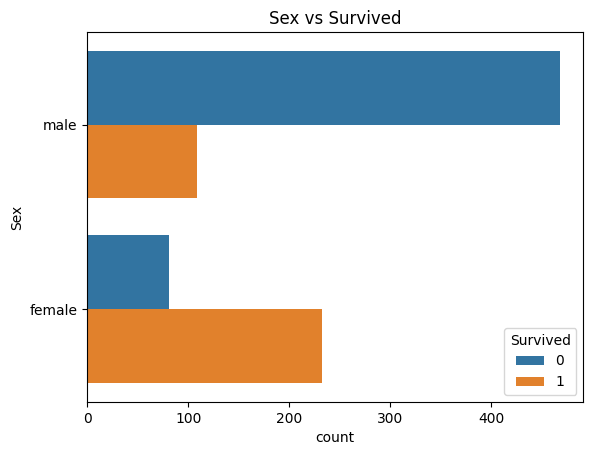

In [59]:
# 畫圖- 針對較重要的特徵進行解釋
# countplot
import matplotlib.pyplot as plt
import seaborn as sns

# 以sex角度 去看生存率
sns.countplot(data=train, y="Sex", hue="Survived")
plt.title("Sex vs Survived")

Text(0.5, 1.0, 'Fare vs Survived')

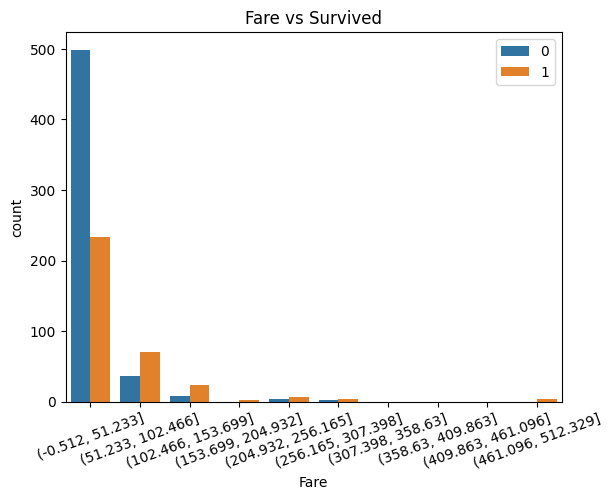

In [58]:
# 畫圖- 針對較重要的特徵進行解釋
# histogram
# 以所花費用 去看生存率

cut_fare = pd.cut(train["Fare"], bins=10)
sns.countplot(x=cut_fare, hue=train["Survived"])

plt.xticks(rotation=20)
plt.legend(loc="upper right")
plt.title("Fare vs Survived")

Text(0.5, 1.0, 'Age vs Survived')

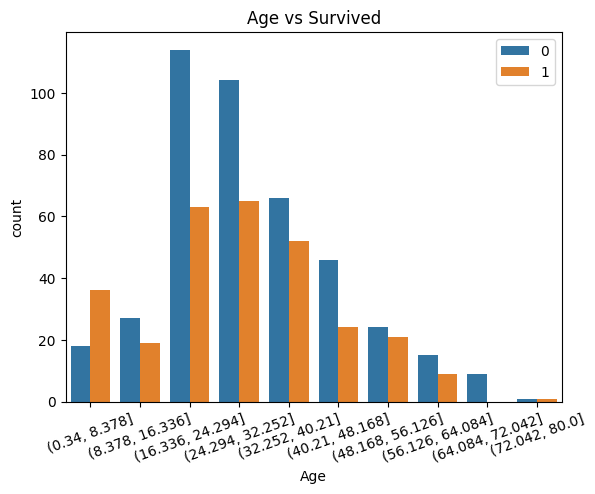

In [57]:
# 畫圖- 針對較重要的特徵進行解釋
# histogram
# 以年紀 去看生存率

cut_fare = pd.cut(train["Age"], bins=10)
sns.countplot(x=cut_fare, hue=train["Survived"])

plt.xticks(rotation=20)
plt.legend(loc="upper right")
plt.title("Age vs Survived")

#小技巧

In [63]:
# 所有資料經過Normalized之後 可以利用資料彼此之間的距離 來判斷整個資料的複雜程度
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Normalized
scaler = MinMaxScaler()
total_scale = pd.DataFrame(scaler.fit_transform(total))

# 分為 x_train, y_train
x_scale = np.array(total_scale.iloc[:len(train)])
y = np.array(train["Survived"])

# TSNE -> n_components: 降低成幾維度
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x_scale)


In [64]:
# 26個欄位 變成2個欄位了
# 理解: 將26維空間的距離 濃縮為 2維空間的距離
x_scale.shape, x_tsne.shape

((891, 26), (891, 2))

In [66]:
x_tsne

array([[-16.023462 ,  -9.421592 ],
       [ 27.982689 ,  -0.6857979],
       [ 14.266521 , -21.648748 ],
       ...,
       [ 14.179455 , -25.661177 ],
       [  5.4961343,  26.723686 ],
       [-34.576797 ,   7.5378504]], dtype=float32)

<Axes: >

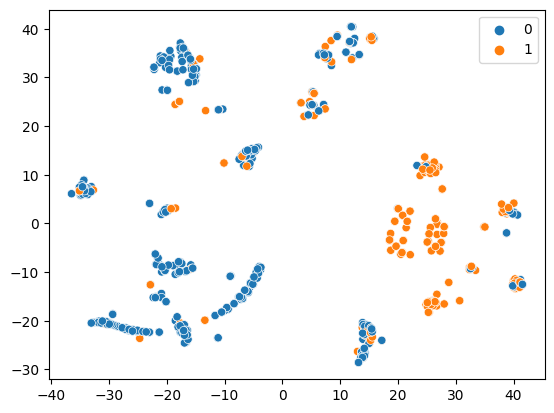

In [67]:
x_left_side_data = x_tsne[:,0]
x_right_side_data = x_tsne[:,1]


# 剛剛: y = np.array(train["Survived"])
sns.scatterplot(x=x_left_side_data, y=x_right_side_data, hue=y)

In [ ]:
# 圖形解析
# 鐵達尼號 算比較簡單的問題
# 生存者 與 死亡者 各自都較聚集
# 僅有少數資料 混雜在一起